## Milestone II - Exploratory Data Analysis

EDA for the multi-domain recession forecasting dataset.

### Import Packages and Load Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# Load the dataset
df = pd.read_pickle('data/milestone_ii_dataset.pkl')
print(f"Dataset shape: {df.shape}")
print(f"Date range: {df.index.get_level_values('date').min()} to {df.index.get_level_values('date').max()}")
print(f"Countries: {df.index.get_level_values('country').unique().tolist()}")

Dataset shape: (5508, 237)
Date range: 1970-01-01 00:00:00 to 2020-12-01 00:00:00
Countries: ['Australia', 'Canada', 'France', 'Germany', 'Italy', 'Japan', 'South Korea', 'UK', 'USA']


### 1. Missing Values Analysis

In [2]:
# Calculate missing values by feature
missing = df.isnull().sum().sort_values(ascending=False)
missing_pct = (missing / len(df) * 100).round(2)

# Display features with missing values
missing_df = pd.DataFrame({'missing_count': missing, 'missing_pct': missing_pct})
missing_df = missing_df[missing_df['missing_count'] > 0]
print(f"Features with missing values: {len(missing_df)} / {len(df.columns)}")
print("\nTop 20 features by missing percentage:")
print(missing_df.head(20))

Features with missing values: 222 / 237

Top 20 features by missing percentage:
                                missing_count  missing_pct
retail_vol_log_1mo                       3861        70.10
retail_vol_log_12mo                      3745        67.99
retail_vol_log_6mo                       3689        66.98
retail_vol_log_3mo                       3641        66.10
epu_rolling_mean_12mo_lag_12mo           2475        44.93
epu_rolling_mean_6mo_lag_12mo            2421        43.95
epu_rolling_mean_12mo_lag_6mo            2421        43.95
epu_rolling_mean_3mo_lag_12mo            2394        43.46
epu_rolling_mean_12mo_lag_3mo            2394        43.46
epu_lag_12mo                             2376        43.14
epu_rolling_mean_12mo_lag_1mo            2376        43.14
epu_log_12mo                             2376        43.14
epu_rolling_std_12mo                     2367        42.97
epu_rolling_mean_6mo_lag_6mo             2367        42.97
epu_rolling_mean_12mo              

In [3]:
# Find earliest date with complete data for each country
complete_dates = []
for country in df.index.get_level_values('country').unique():
    country_df = df.xs(country, level='country')
    # First row with no missing values
    complete_mask = ~country_df.isnull().any(axis=1)
    if complete_mask.any():
        first_complete = country_df[complete_mask].index.min()
        complete_dates.append({'country': country, 'first_complete_date': first_complete})

complete_df = pd.DataFrame(complete_dates)
print("First date with complete data by country:")
print(complete_df.sort_values('first_complete_date'))
print(f"\nRecommended start date for analysis: {complete_df['first_complete_date'].max()}")

First date with complete data by country:
       country first_complete_date
8          USA          1992-07-01
1       Canada          1993-04-01
2       France          1994-06-01
3      Germany          1995-03-01
5        Japan          1998-01-01
7           UK          1999-07-01
4        Italy          1999-11-01
0    Australia          1999-12-01
6  South Korea          2002-02-01

Recommended start date for analysis: 2002-02-01 00:00:00


In [4]:

# Feature data coverage: earliest available date, country coverage, and overall missing %
# Helps identify features with limited historical data that may be candidates for removal

exclude_cols = ['pre_recession', 'oecd_rec', 'technical_rec']
country_cols = [c for c in df.columns if c.startswith('country_')]
feature_cols = [c for c in df.columns if c not in exclude_cols + country_cols]

records = []
for col in feature_cols:
    non_null = df[col].dropna()
    if len(non_null) == 0:
        records.append({
            'feature': col,
            'missing_pct': 100.0,
            'earliest_data': pd.NaT,
            'latest_data': pd.NaT,
            'years_of_data': 0,
            'countries_with_data': 0,
            'non_null_rows': 0
        })
        continue

    dates = non_null.index.get_level_values('date')
    countries_with_data = non_null.index.get_level_values('country').nunique()
    earliest = dates.min()
    latest = dates.max()
    years = (latest - earliest).days / 365.25

    records.append({
        'feature': col,
        'missing_pct': round(df[col].isnull().sum() / len(df) * 100, 1),
        'earliest_data': earliest,
        'latest_data': latest,
        'years_of_data': round(years, 1),
        'countries_with_data': countries_with_data,
        'non_null_rows': len(non_null)
    })

coverage = pd.DataFrame(records).sort_values('earliest_data', ascending=False)

# Display the full table
pd.set_option('display.max_rows', None)
print(f"Feature Data Coverage ({len(coverage)} features)")
print("="*100)
print(coverage[['feature', 'missing_pct', 'earliest_data', 'years_of_data', 'countries_with_data', 'non_null_rows']].to_string(index=False))
pd.reset_option('display.max_rows')

# Summary: features with >50% missing
high_missing = coverage[coverage['missing_pct'] > 50]
print(f"\n{'='*100}")
print(f"Features with >50% missing: {len(high_missing)}")
print(f"Features with >40% missing: {len(coverage[coverage['missing_pct'] > 40])}")
print(f"Features with >30% missing: {len(coverage[coverage['missing_pct'] > 30])}")
print(f"Features with 0% missing:   {len(coverage[coverage['missing_pct'] == 0])}")


Feature Data Coverage (225 features)
                                        feature  missing_pct earliest_data  years_of_data  countries_with_data  non_null_rows
                 vix_rolling_mean_12mo_lag_12mo         43.0    1991-12-01           29.0                    9           3141
                  vix_rolling_mean_6mo_lag_12mo         42.0    1991-06-01           29.5                    9           3195
                  vix_rolling_mean_12mo_lag_6mo         42.0    1991-06-01           29.5                    9           3195
                  vix_rolling_mean_3mo_lag_12mo         41.5    1991-03-01           29.8                    9           3222
                  vix_rolling_mean_12mo_lag_3mo         41.5    1991-03-01           29.8                    9           3222
                  vix_rolling_mean_12mo_lag_1mo         41.2    1991-01-01           29.9                    9           3240
                                   vix_lag_12mo         41.2    1991-01-01       

In [7]:

# Feature data coverage by country
# Shows missing %, earliest available date, and years of data for each feature per country

countries = df.index.get_level_values('country').unique().sort_values()

# --- 1. Summary table: per-country missing data overview ---
summary_rows = []
for country in countries:
    country_df = df.xs(country, level='country')
    n_rows = len(country_df)
    missing_pcts = country_df[feature_cols].isnull().sum() / n_rows * 100
    summary_rows.append({
        'Country': country,
        'Total rows': n_rows,
        'Features >50% missing': int((missing_pcts > 50).sum()),
        'Features >30% missing': int((missing_pcts > 30).sum()),
        'Features 0% missing': int((missing_pcts == 0).sum()),
        'Avg missing %': round(missing_pcts.mean(), 1)
    })

summary_df = pd.DataFrame(summary_rows).set_index('Country')
print("Per-Country Missing Data Summary")
print("=" * 80)
print(summary_df.to_string())

base_features = [f for f in feature_cols
                 if '_lag_' not in f and '_rolling_' not in f]

country_missing = pd.DataFrame(index=base_features, columns=countries, dtype=float)
for country in countries:
    country_df = df.xs(country, level='country')
    n_rows = len(country_df)
    for col in base_features:
        country_missing.loc[col, country] = round(
            country_df[col].isnull().sum() / n_rows * 100, 1
        )


# --- 3. Features with cross-country variation in coverage ---
# Highlight features that are available for some countries but not others
missing_range = country_missing.astype(float).max(axis=1) - country_missing.astype(float).min(axis=1)
varied = missing_range[missing_range > 10].sort_values(ascending=False)
if len(varied) > 0:
    print(f"\nBase features with >10pp cross-country variation in missing %: {len(varied)}")
    varied_df = country_missing.loc[varied.index]
    print(varied_df.to_string())
else:
    print("\nAll base features have consistent coverage across countries (within 10pp).")

# --- 4. Detailed per-country tables ---
pd.set_option('display.max_rows', None)
for country in countries:
    country_df = df.xs(country, level='country')
    n_rows = len(country_df)

    records = []
    for col in feature_cols:
        non_null = country_df[col].dropna()
        missing_pct = round((n_rows - len(non_null)) / n_rows * 100, 1)

        if len(non_null) > 0:
            earliest = non_null.index.min()
            latest = non_null.index.max()
            years = round((latest - earliest).days / 365.25, 1)
        else:
            earliest = pd.NaT
            latest = pd.NaT
            years = 0

        records.append({
            'feature': col,
            'missing_pct': missing_pct,
            'earliest_data': earliest,
            'years_of_data': years,
            'non_null_rows': len(non_null)
        })

    cov = pd.DataFrame(records).sort_values('earliest_data', ascending=False)
    print(f"\n{'=' * 90}")
    print(f"Feature Data Coverage: {country} ({n_rows} total rows)")
    print(f"{'=' * 90}")
    print(cov[['feature', 'missing_pct', 'earliest_data', 'years_of_data', 'non_null_rows']].to_string(index=False))

    # Per-country summary
    high_missing = cov[cov['missing_pct'] > 50]
    print(f"\n  Features >50% missing: {len(high_missing)}")
    print(f"  Features >30% missing: {len(cov[cov['missing_pct'] > 30])}")
    print(f"  Features  0% missing: {len(cov[cov['missing_pct'] == 0])}")

pd.reset_option('display.max_rows')


Per-Country Missing Data Summary
             Total rows  Features >50% missing  Features >30% missing  Features 0% missing  Avg missing %
Country                                                                                                  
Australia           612                     27                     71                    9           18.8
Canada              612                      4                     55                   13           13.6
France              612                      4                     58                   12           15.3
Germany             612                      4                     89                   13           18.9
Italy               612                     41                    100                    9           25.4
Japan               612                      4                     90                   11           20.3
South Korea         612                     42                    158                    4           35.8
UK           

### 2. Target Distribution

In [8]:
# Overall target distribution
print("Target Distribution (pre_recession):")
print(df['pre_recession'].value_counts())
print(f"\nClass imbalance ratio: {df['pre_recession'].value_counts()[0] / df['pre_recession'].value_counts()[1]:.1f}:1")
print(f"Positive class percentage: {df['pre_recession'].mean():.2%}")

Target Distribution (pre_recession):
pre_recession
0    4334
1    1174
Name: count, dtype: int64

Class imbalance ratio: 3.7:1
Positive class percentage: 21.31%


In [9]:
# Pre-recession periods by country
pre_rec_by_country = df.groupby(level='country')['pre_recession'].agg(['sum', 'mean'])
pre_rec_by_country.columns = ['pre_recession_months', 'pre_recession_pct']
pre_rec_by_country['pre_recession_pct'] = pre_rec_by_country['pre_recession_pct'].map('{:.2%}'.format)
print("Pre-recession periods by country:")
print(pre_rec_by_country)

Pre-recession periods by country:
             pre_recession_months pre_recession_pct
country                                            
Australia                     148            24.18%
Canada                        144            23.53%
France                        120            19.61%
Germany                       128            20.92%
Italy                         127            20.75%
Japan                         135            22.06%
South Korea                   144            23.53%
UK                            108            17.65%
USA                           120            19.61%


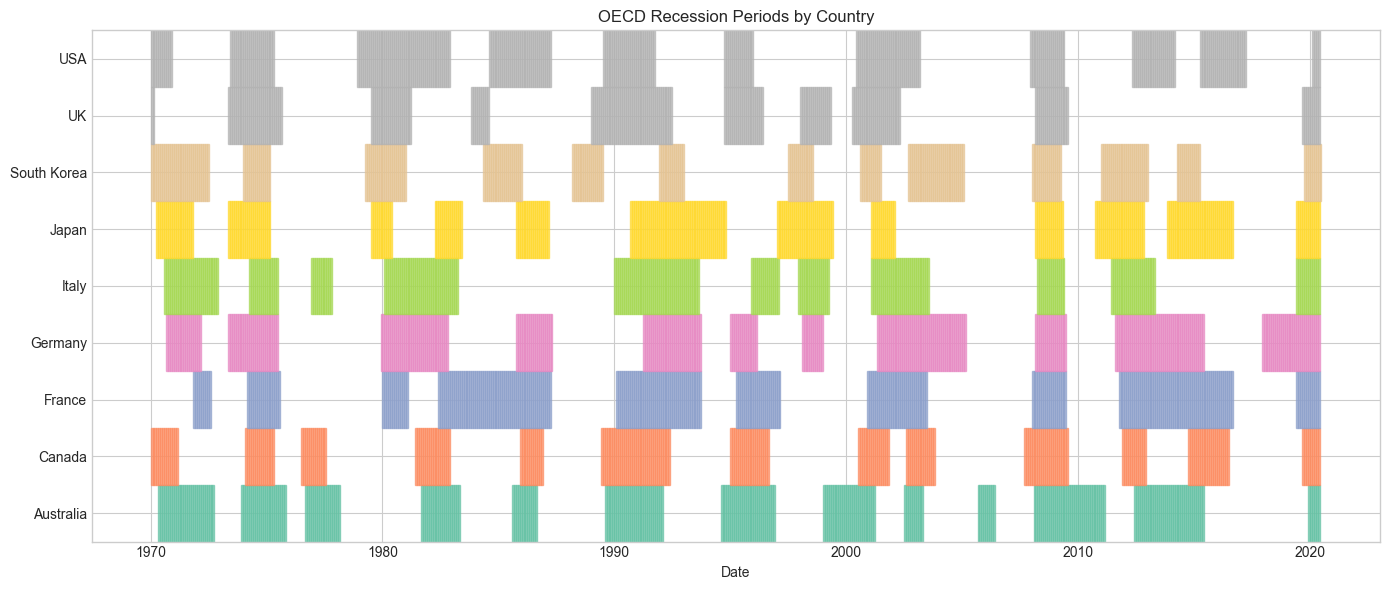

In [10]:
# Visualize recession timing across countries
fig, ax = plt.subplots(figsize=(14, 6))

countries = df.index.get_level_values('country').unique()
colors = plt.cm.Set2(np.linspace(0, 1, len(countries)))

for i, country in enumerate(countries):
    country_df = df.xs(country, level='country')
    recession_periods = country_df[country_df['oecd_rec'] == True].index
    
    for date in recession_periods:
        ax.axvspan(date, date + pd.DateOffset(months=1), 
                   ymin=i/len(countries), ymax=(i+1)/len(countries),
                   alpha=0.7, color=colors[i], label=country if date == recession_periods[0] else '')

ax.set_yticks([(i + 0.5) / len(countries) for i in range(len(countries))])
ax.set_yticklabels(countries)
ax.set_xlabel('Date')
ax.set_title('OECD Recession Periods by Country')
plt.tight_layout()
plt.show()

### 3. Feature Distributions

In [11]:
# Summary statistics for key raw indicators
raw_indicators = ['real_gdp', 'cpi', 'unemployment_rate', '10_yr_yld', '3_mo_yld', 
                  'vix', 'oil', 'epu', 'yield_curve', 'sahm_value']
raw_indicators = [c for c in raw_indicators if c in df.columns]

print("Summary Statistics for Key Indicators:")
df[raw_indicators].describe().round(2)

Summary Statistics for Key Indicators:


,real_gdp,cpi,unemployment_rate,10_yr_yld,3_mo_yld,vix,oil,epu,yield_curve,sahm_value
count,4.509000e+03,5307.00,4451.00,4657.00,4847.00,3348.00,5508.00,3240.00,4465.00,4334.00
mean,3.721453e+13,66.92,6.74,6.09,5.55,19.48,36.02,129.01,0.84,0.33
std,8.811005e+13,28.97,2.76,3.79,4.65,7.77,27.51,84.96,1.50,0.68
min,1.247300e+11,4.64,1.00,-0.65,-0.54,10.13,3.31,11.29,-13.30,0.00
25%,3.405420e+11,44.66,4.62,3.18,1.64,13.93,16.75,77.44,0.08,0.00
50%,5.085678e+11,71.90,6.80,5.54,4.84,17.55,27.54,104.82,0.95,0.07
75%,1.536685e+13,93.34,8.80,8.68,8.35,23.22,49.78,149.97,1.80,0.37
max,4.696068e+14,109.90,14.80,17.32,23.10,62.67,133.93,1141.80,5.57,9.43


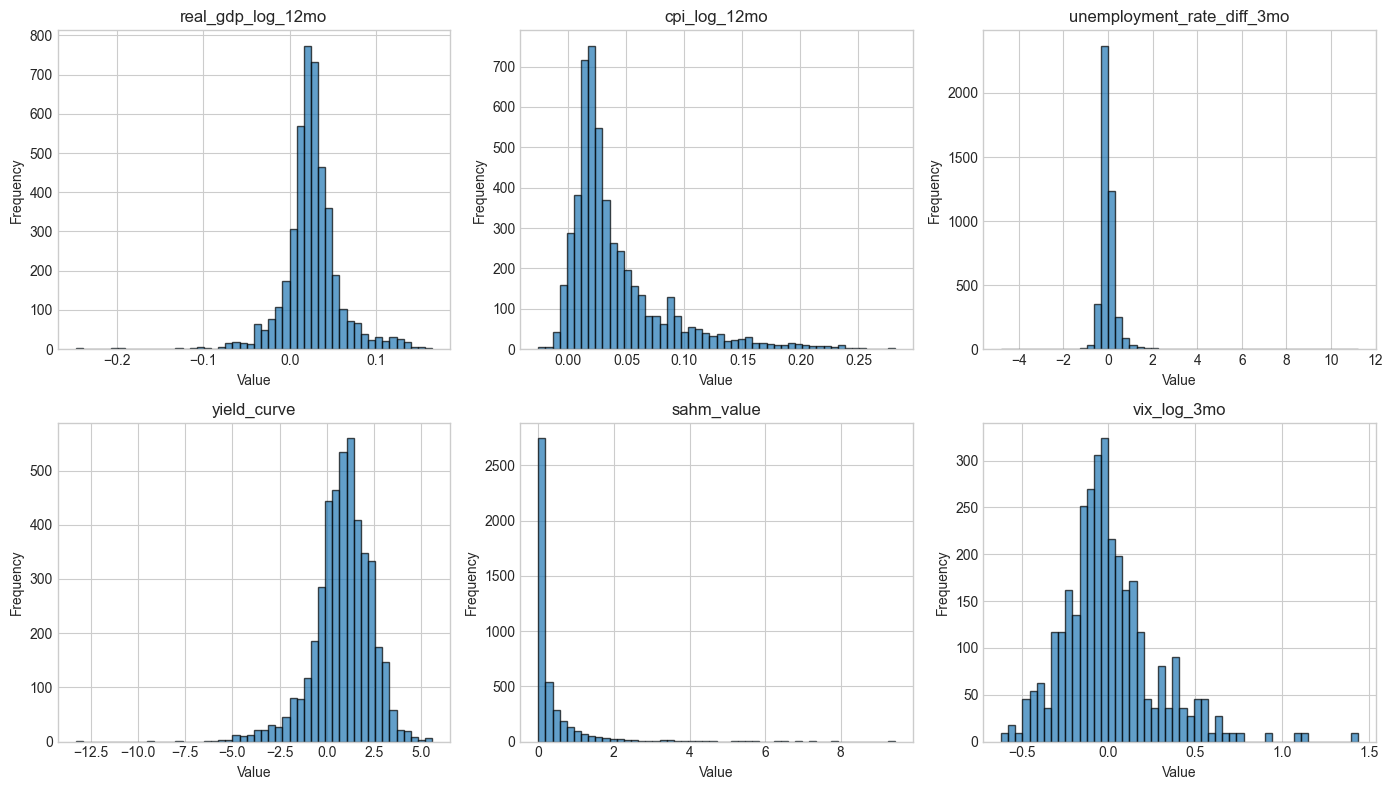

In [12]:
# Distribution plots for key transformed features
transformed_features = ['real_gdp_log_12mo', 'cpi_log_12mo', 'unemployment_rate_diff_3mo',
                        'yield_curve', 'sahm_value', 'vix_log_3mo']
transformed_features = [c for c in transformed_features if c in df.columns]

fig, axes = plt.subplots(2, 3, figsize=(14, 8))
axes = axes.flatten()

for i, col in enumerate(transformed_features):
    df[col].dropna().hist(bins=50, ax=axes[i], edgecolor='black', alpha=0.7)
    axes[i].set_title(col)
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

### 4. Correlation Analysis

In [13]:
# Feature correlations with target
# Exclude one-hot encoded country columns and boolean columns
feature_cols = [c for c in df.columns if not c.startswith('country_') 
                and c not in ['pre_recession', 'oecd_rec', 'technical_rec']]

target_corr = df[feature_cols].corrwith(df['pre_recession']).sort_values(key=abs, ascending=False)

print("Top 20 features correlated with pre_recession target:")
print(target_corr.head(20).round(3))

print("\nBottom 20 features (negative correlation):")
print(target_corr.tail(20).round(3))

Top 20 features correlated with pre_recession target:
cli_lag_1mo                       0.358
cli_dev_lag_1mo                   0.358
cli_dev                           0.357
cli                               0.357
cli_dev_lag_3mo                   0.341
cli_lag_3mo                       0.341
cli_lag_6mo                       0.276
cli_dev_lag_6mo                   0.276
ind_out_log_12mo                  0.247
unemployment_rate_diff_12mo      -0.219
real_gdp_log_12mo                 0.206
comp_consumer_conf_lag_3mo        0.205
comp_consumer_conf_dev_lag_3mo    0.205
comp_consumer_conf_lag_1mo        0.203
comp_consumer_conf_dev_lag_1mo    0.203
cli_diff_12mo                     0.198
comp_consumer_conf_dev            0.195
comp_consumer_conf                0.195
3_mo_yld_diff_6mo                 0.188
ind_out_log_6mo                   0.188
dtype: float64

Bottom 20 features (negative correlation):
cli_diff_1mo                                     -0.008
ind_out                        

c:\Users\Matthew\Desktop\School\Milestone 2\Repo\.venv\Lib\site-packages\numpy\_core\_methods.py:132: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


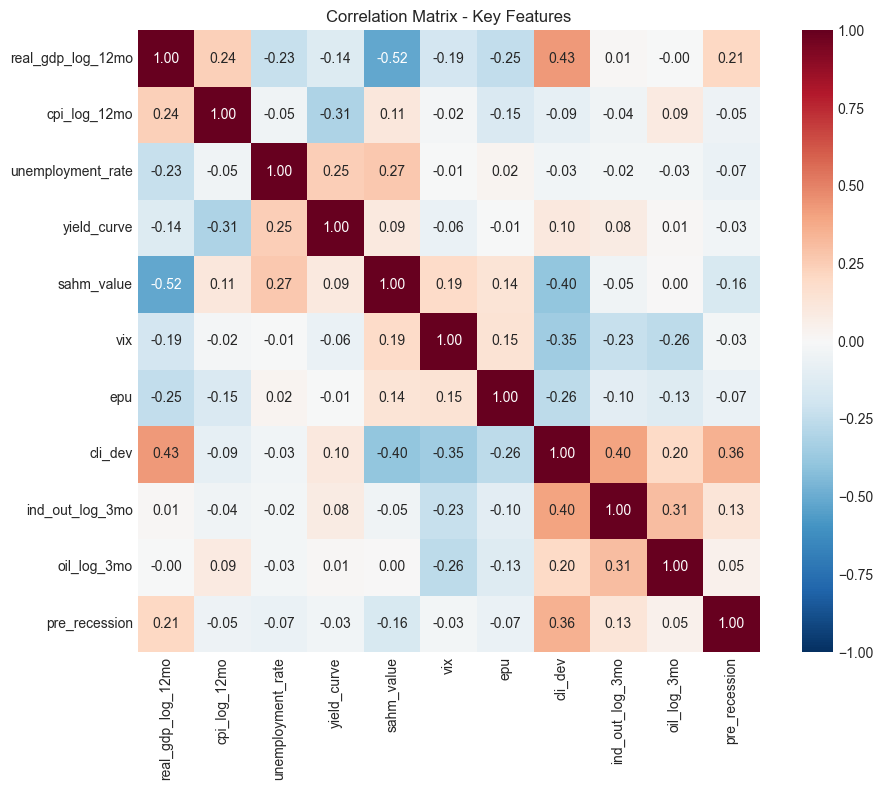

In [14]:
# Correlation heatmap for key features
key_features = ['real_gdp_log_12mo', 'cpi_log_12mo', 'unemployment_rate', 
                'yield_curve', 'sahm_value', 'vix', 'epu', 'cli_dev',
                'ind_out_log_3mo', 'oil_log_3mo', 'pre_recession']
key_features = [c for c in key_features if c in df.columns]

corr_matrix = df[key_features].corr()

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='RdBu_r', center=0,
            square=True, ax=ax, vmin=-1, vmax=1)
ax.set_title('Correlation Matrix - Key Features')
plt.tight_layout()
plt.show()

### 5. Time Series Patterns

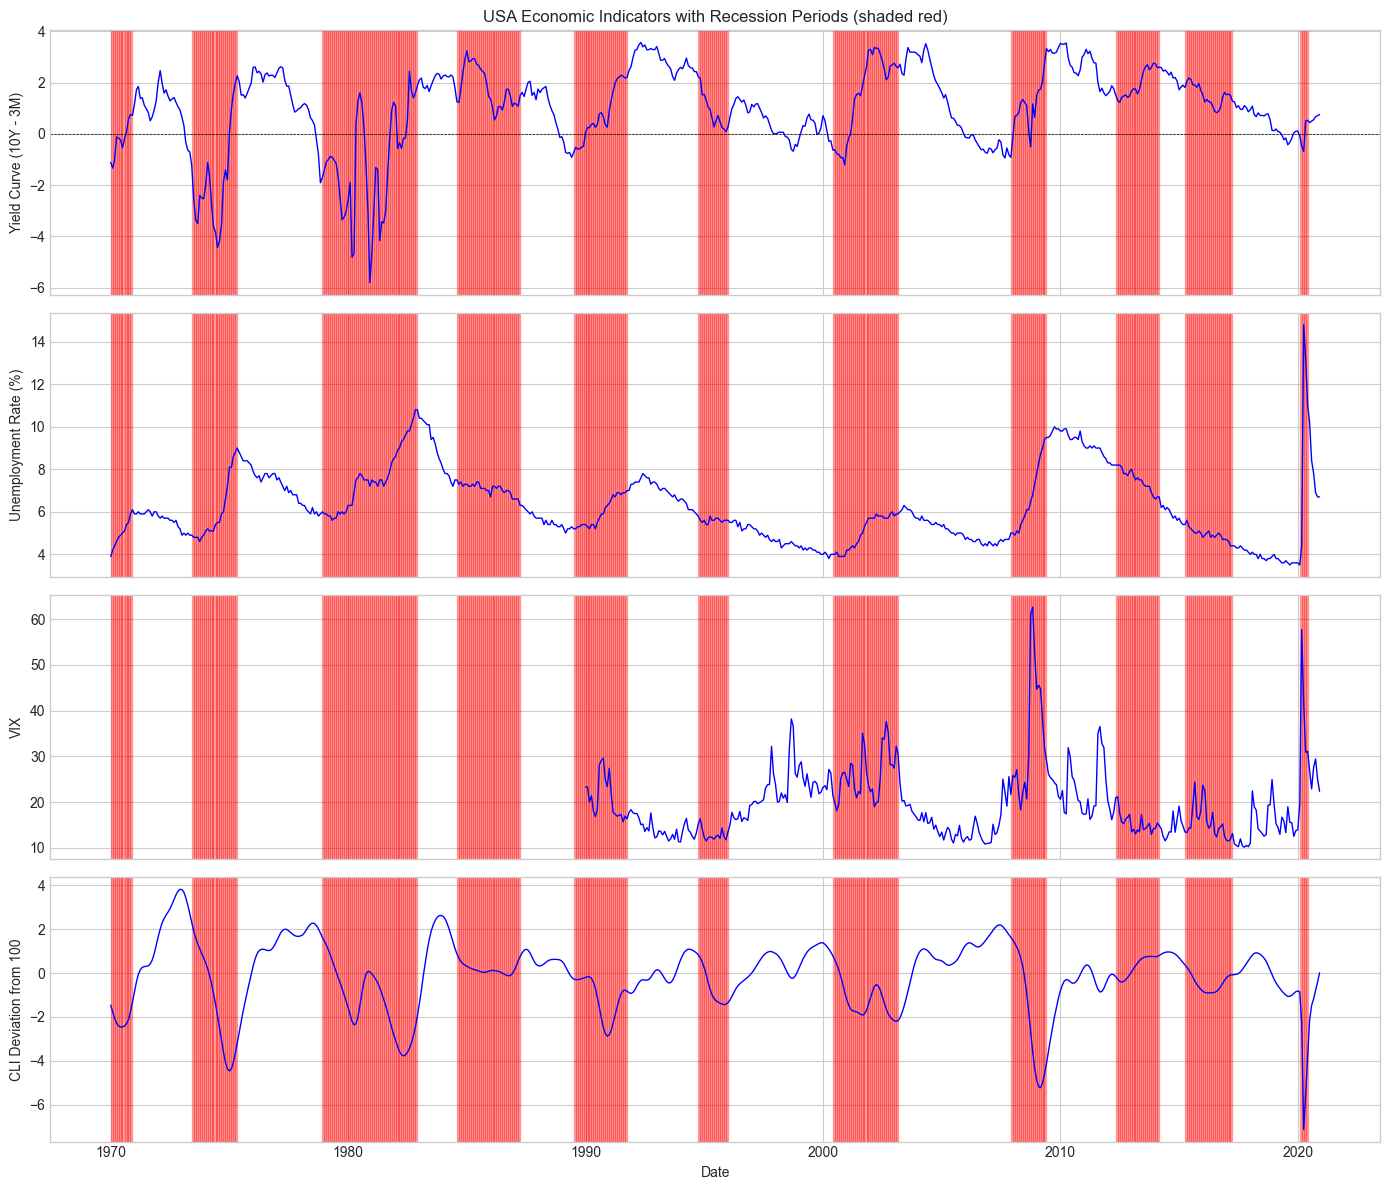

In [15]:
# Plot key indicators over time for USA with recession shading
usa_df = df.xs('USA', level='country')

fig, axes = plt.subplots(4, 1, figsize=(14, 12), sharex=True)

indicators = ['yield_curve', 'unemployment_rate', 'vix', 'cli_dev']
titles = ['Yield Curve (10Y - 3M)', 'Unemployment Rate (%)', 'VIX', 'CLI Deviation from 100']

for ax, indicator, title in zip(axes, indicators, titles):
    if indicator in usa_df.columns:
        ax.plot(usa_df.index, usa_df[indicator], 'b-', linewidth=1)
        ax.set_ylabel(title)
        
        # Shade recession periods
        recession_mask = usa_df['oecd_rec'] == True
        for date in usa_df[recession_mask].index:
            ax.axvspan(date, date + pd.DateOffset(months=1), alpha=0.3, color='red')
        
        # Add zero line for yield curve
        if indicator == 'yield_curve':
            ax.axhline(y=0, color='black', linestyle='--', linewidth=0.5)

axes[0].set_title('USA Economic Indicators with Recession Periods (shaded red)')
axes[-1].set_xlabel('Date')
plt.tight_layout()
plt.show()

### 6. Pre-Recession vs Normal Periods

C:\Users\Matthew\AppData\Local\Temp\ipykernel_88540\596729164.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[i].boxplot([normal, pre_rec], labels=['Normal', 'Pre-Recession'])
C:\Users\Matthew\AppData\Local\Temp\ipykernel_88540\596729164.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[i].boxplot([normal, pre_rec], labels=['Normal', 'Pre-Recession'])
C:\Users\Matthew\AppData\Local\Temp\ipykernel_88540\596729164.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[i].boxplot([normal, pre_rec], labels=['Normal', 'Pre-Recession'])
C:\Users\Matthew\AppData\Local\Temp\ipykernel_88540\596729164.py:13

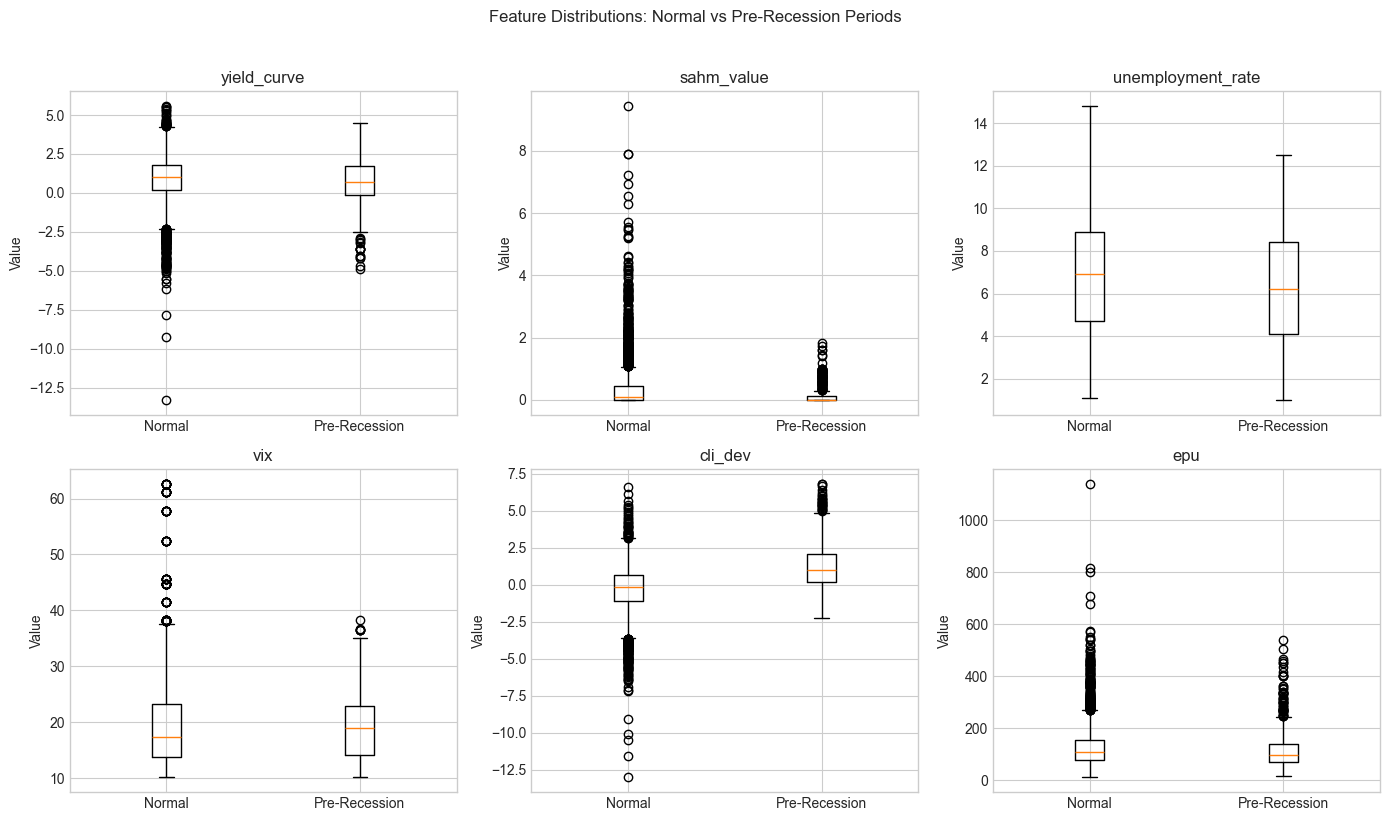

In [16]:
# Compare feature distributions by target class
comparison_features = ['yield_curve', 'sahm_value', 'unemployment_rate', 'vix',
                       'cli_dev', 'epu']
comparison_features = [c for c in comparison_features if c in df.columns]

fig, axes = plt.subplots(2, 3, figsize=(14, 8))
axes = axes.flatten()

for i, col in enumerate(comparison_features):
    normal = df[df['pre_recession'] == 0][col].dropna()
    pre_rec = df[df['pre_recession'] == 1][col].dropna()
    
    axes[i].boxplot([normal, pre_rec], labels=['Normal', 'Pre-Recession'])
    axes[i].set_title(col)
    axes[i].set_ylabel('Value')

plt.suptitle('Feature Distributions: Normal vs Pre-Recession Periods', y=1.02)
plt.tight_layout()
plt.show()

In [17]:
# Statistical comparison of means
print("Mean values by target class:")
comparison_stats = df.groupby('pre_recession')[comparison_features].mean().T
comparison_stats.columns = ['Normal', 'Pre-Recession']
comparison_stats['Difference'] = comparison_stats['Pre-Recession'] - comparison_stats['Normal']
comparison_stats['Pct_Change'] = (comparison_stats['Difference'] / comparison_stats['Normal'].abs() * 100).round(1)
print(comparison_stats.round(3))

Mean values by target class:
                    Normal  Pre-Recession  Difference  Pct_Change
yield_curve          0.861          0.741      -0.120       -13.9
sahm_value           0.387          0.119      -0.268       -69.3
unemployment_rate    6.830          6.384      -0.446        -6.5
vix                 19.592         19.057      -0.535        -2.7
cli_dev             -0.314          1.140       1.454       462.9
epu                132.090        117.713     -14.378       -10.9


### 7. Country Comparisons

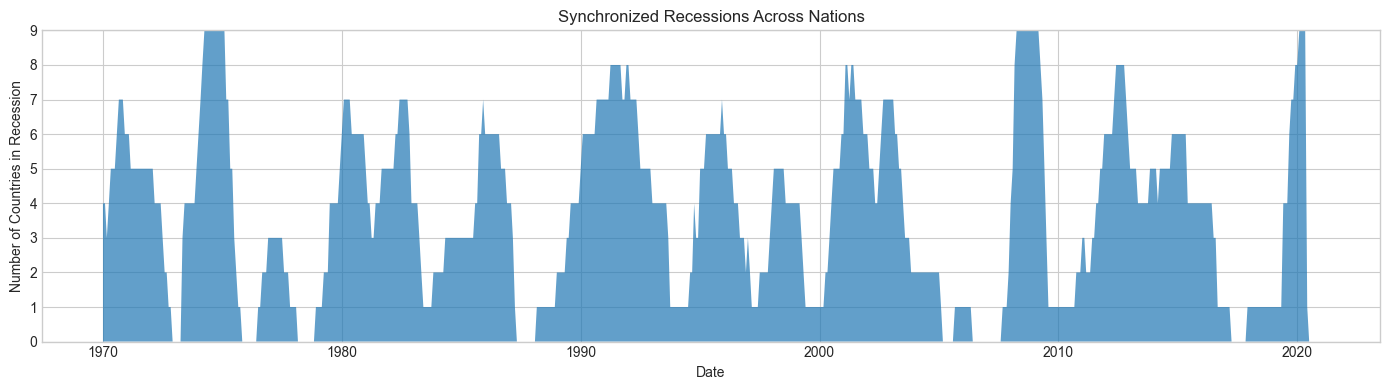


Maximum synchronized recessions: 9
Months with 5+ countries in recession: 239


In [18]:
# Count synchronized recessions (how many countries in recession at same time)
recession_by_date = df.groupby(level='date')['oecd_rec'].sum()

fig, ax = plt.subplots(figsize=(14, 4))
ax.fill_between(recession_by_date.index, recession_by_date.values, alpha=0.7)
ax.set_xlabel('Date')
ax.set_ylabel('Number of Countries in Recession')
ax.set_title('Synchronized Recessions Across Nations')
ax.set_ylim(0, 9)
plt.tight_layout()
plt.show()

print("\nMaximum synchronized recessions:", int(recession_by_date.max()))
print("Months with 5+ countries in recession:", (recession_by_date >= 5).sum())

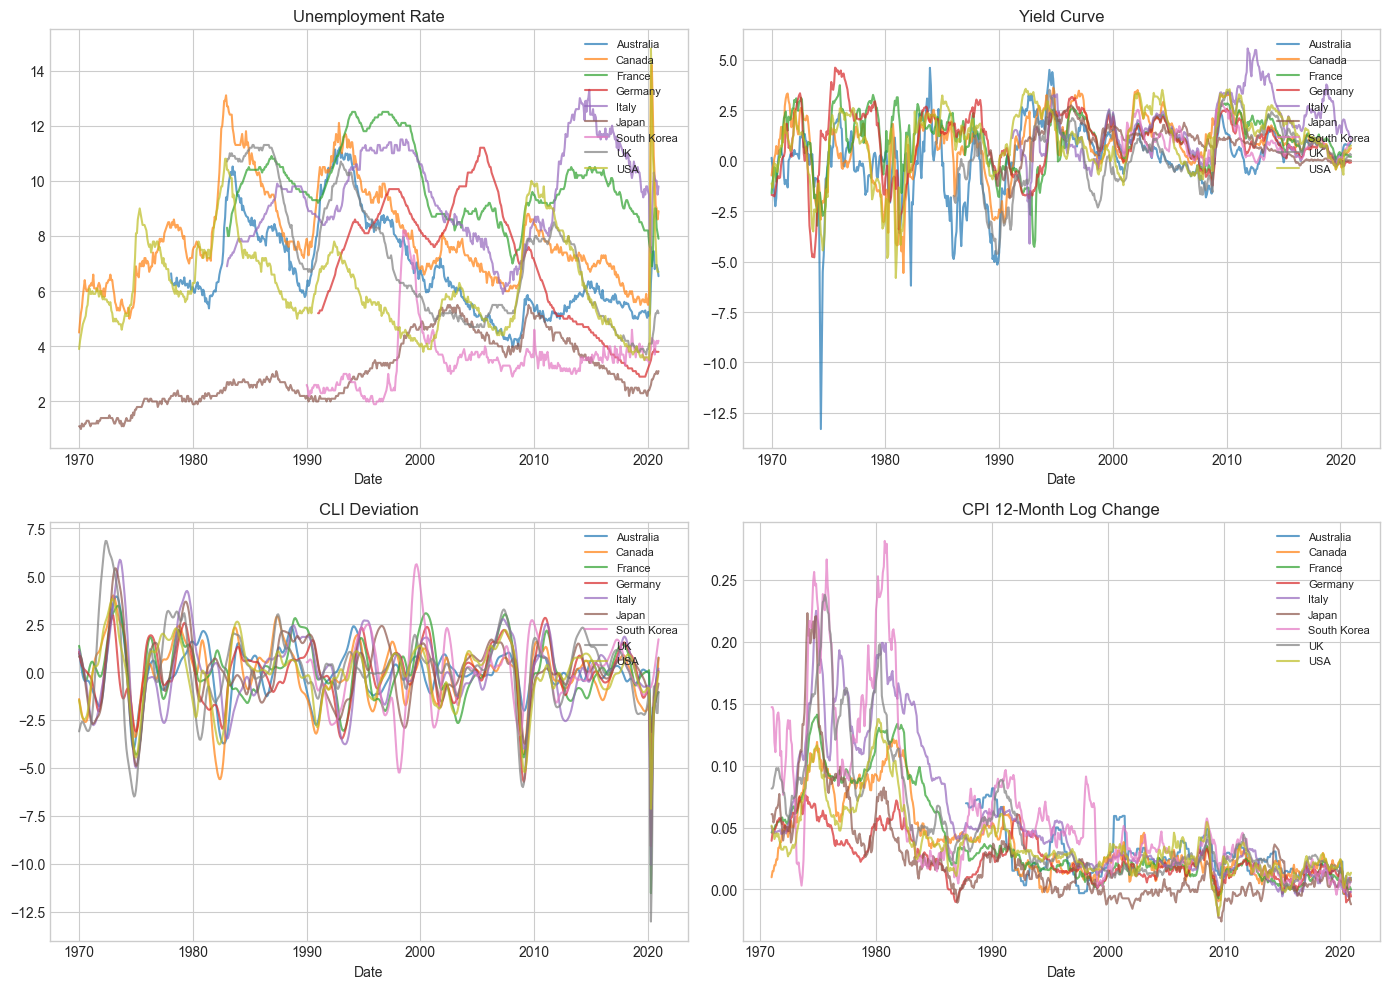

In [19]:
# Compare key indicators across countries
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

indicators = ['unemployment_rate', 'yield_curve', 'cli_dev', 'cpi_log_12mo']
titles = ['Unemployment Rate', 'Yield Curve', 'CLI Deviation', 'CPI 12-Month Log Change']

for ax, indicator, title in zip(axes.flatten(), indicators, titles):
    if indicator in df.columns:
        for country in df.index.get_level_values('country').unique():
            country_data = df.xs(country, level='country')[indicator]
            ax.plot(country_data.index, country_data, label=country, alpha=0.7)
        ax.set_title(title)
        ax.set_xlabel('Date')
        ax.legend(loc='upper right', fontsize=8)

plt.tight_layout()
plt.show()

### 8. Yield Curve Analysis

In [20]:
# Analyze yield curve inversions and their lead time to recessions
print("Yield Curve Inversion Analysis by Country:")
print("="*60)

for country in df.index.get_level_values('country').unique():
    country_df = df.xs(country, level='country').copy()
    
    # Find inversion periods
    inversions = country_df[country_df['yield_curve'] < 0].index
    
    # Find recession starts
    rec = country_df['oecd_rec'].astype(int)
    recession_starts = rec.index[(rec == 1) & (rec.shift(1) == 0)]
    
    print(f"\n{country}:")
    print(f"  Total months with inverted yield curve: {len(inversions)}")
    print(f"  Number of recessions: {len(recession_starts)}")
    
    # For each recession, find if there was a preceding inversion
    for rec_start in recession_starts:
        # Look back 24 months for inversions
        lookback_start = rec_start - pd.DateOffset(months=24)
        preceding_inversions = inversions[(inversions >= lookback_start) & (inversions < rec_start)]
        
        if len(preceding_inversions) > 0:
            first_inversion = preceding_inversions.min()
            lead_months = (rec_start - first_inversion).days // 30
            print(f"  Recession {rec_start.strftime('%Y-%m')}: Inversion {lead_months} months prior")
        else:
            print(f"  Recession {rec_start.strftime('%Y-%m')}: No inversion in prior 24 months")

Yield Curve Inversion Analysis by Country:

Australia:
  Total months with inverted yield curve: 228
  Number of recessions: 13
  Recession 1970-05: Inversion 2 months prior
  Recession 1973-12: Inversion 7 months prior
  Recession 1976-09: Inversion 24 months prior
  Recession 1981-09: Inversion 22 months prior
  Recession 1985-08: Inversion 7 months prior
  Recession 1989-08: Inversion 14 months prior
  Recession 1994-08: No inversion in prior 24 months
  Recession 1999-01: No inversion in prior 24 months
  Recession 2002-07: Inversion 24 months prior
  Recession 2005-09: Inversion 18 months prior
  Recession 2008-02: Inversion 24 months prior
  Recession 2012-06: Inversion 10 months prior
  Recession 2019-12: Inversion 4 months prior

Canada:
  Total months with inverted yield curve: 129
  Number of recessions: 12
  Recession 1974-02: Inversion 6 months prior
  Recession 1976-07: Inversion 24 months prior
  Recession 1981-06: Inversion 24 months prior
  Recession 1985-12: No inversi

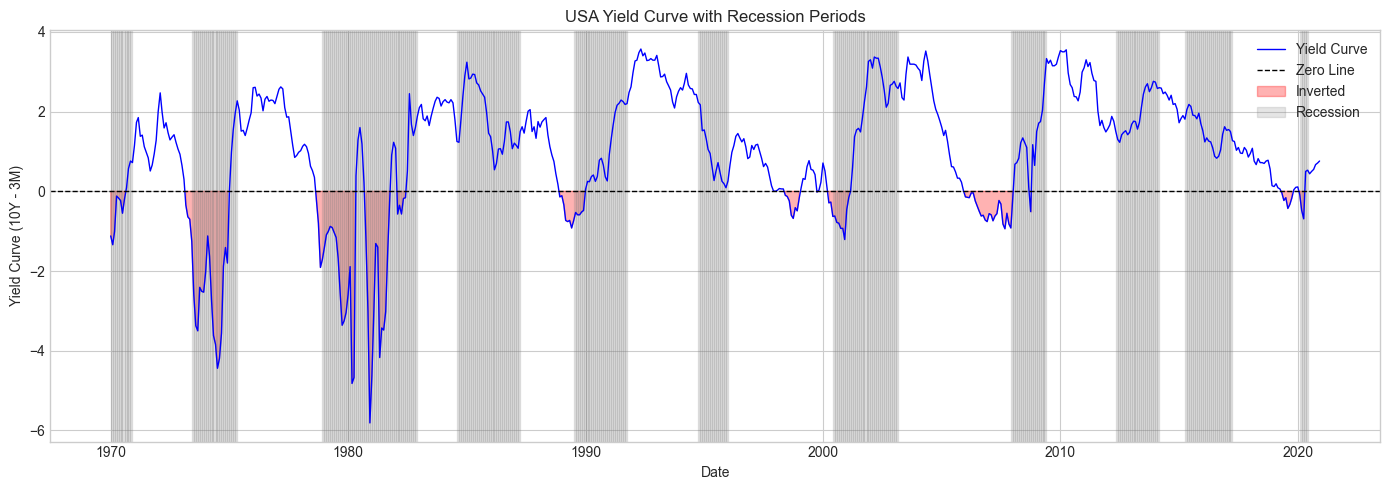

In [21]:
# Visualize yield curve with recession overlay for USA
usa_df = df.xs('USA', level='country')

fig, ax = plt.subplots(figsize=(14, 5))

ax.plot(usa_df.index, usa_df['yield_curve'], 'b-', linewidth=1, label='Yield Curve')
ax.axhline(y=0, color='black', linestyle='--', linewidth=1, label='Zero Line')
ax.fill_between(usa_df.index, usa_df['yield_curve'], 0, 
                where=(usa_df['yield_curve'] < 0), alpha=0.3, color='red', label='Inverted')

# Shade recession periods
recession_mask = usa_df['oecd_rec'] == True
for i, date in enumerate(usa_df[recession_mask].index):
    ax.axvspan(date, date + pd.DateOffset(months=1), alpha=0.2, color='gray',
               label='Recession' if i == 0 else '')

ax.set_xlabel('Date')
ax.set_ylabel('Yield Curve (10Y - 3M)')
ax.set_title('USA Yield Curve with Recession Periods')
ax.legend(loc='upper right')
plt.tight_layout()
plt.show()

### 9. Summary Statistics

In [22]:
# Final summary
print("Dataset Summary")
print("="*60)
print(f"Total observations: {len(df)}")
print(f"Total features: {len(df.columns)}")
print(f"Date range: {df.index.get_level_values('date').min().strftime('%Y-%m')} to {df.index.get_level_values('date').max().strftime('%Y-%m')}")
print(f"Countries: {len(df.index.get_level_values('country').unique())}")
print(f"\nTarget distribution:")
print(f"  Normal periods: {(df['pre_recession'] == 0).sum()} ({(df['pre_recession'] == 0).mean():.1%})")
print(f"  Pre-recession: {(df['pre_recession'] == 1).sum()} ({(df['pre_recession'] == 1).mean():.1%})")
print(f"\nMissing values: {df.isnull().sum().sum()} total across all features")
print(f"Features with no missing: {(df.isnull().sum() == 0).sum()}")

Dataset Summary
Total observations: 5508
Total features: 237
Date range: 1970-01 to 2020-12
Countries: 9

Target distribution:
  Normal periods: 4334 (78.7%)
  Pre-recession: 1174 (21.3%)

Missing values: 247143 total across all features
Features with no missing: 15


### 10. XGBoost Baseline Model

Test a baseline XGBoost classifier with time-based cross-validation. XGBoost handles missing values natively and doesn't require feature scaling.

**Key considerations:**
- **Time-based CV**: Split by date to avoid look-ahead bias (all countries at time t in same fold)
- **Class imbalance**: Use `scale_pos_weight` to handle rare recession events
- **Feature leakage**: Exclude `oecd_rec` and `technical_rec` (these are recession indicators)

In [23]:
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, auc

# Reset index to work with date column
df_flat = df.reset_index()

# Drop COVID-19 period (2020 onwards) - exogenous shock with different dynamics
df_flat = df_flat[df_flat['date'] < '2020-01-01']
print(f"Filtered to pre-COVID period: {df_flat['date'].min().strftime('%Y-%m')} to {df_flat['date'].max().strftime('%Y-%m')}")

# Identify feature columns (exclude leaky and non-feature columns)
leaky_cols = ['oecd_rec', 'technical_rec', 'pre_recession']
non_feature_cols = ['date', 'country']
feature_cols = [c for c in df_flat.columns if c not in leaky_cols + non_feature_cols]

print(f"Total features: {len(feature_cols)}")
print(f"Total observations: {len(df_flat)}")

X = df_flat[feature_cols].copy()
y = df_flat['pre_recession']

# Replace inf/-inf with NaN (XGBoost handles NaN but not inf)
inf_count = np.isinf(X).sum().sum()
X = X.replace([np.inf, -np.inf], np.nan)
print(f"Replaced {inf_count} infinite values with NaN")

# Handle class imbalance
scale_pos_weight = (y == 0).sum() / (y == 1).sum()
print(f"Class imbalance ratio: {scale_pos_weight:.2f}:1")
print(f"Positive class: {y.sum()} ({y.mean():.1%})")

Filtered to pre-COVID period: 1970-01 to 2019-12
Total features: 234
Total observations: 5400
Replaced 471 infinite values with NaN
Class imbalance ratio: 3.60:1
Positive class: 1173 (21.7%)


In [24]:
# Investigate Fold 5 issue: check pre-recession labels in 2019
df_check = df.reset_index()
df_2019 = df_check[(df_check['date'] >= '2019-01-01') & (df_check['date'] < '2020-01-01')]
print("2019 Pre-recession labels (these precede COVID recessions):")
print(f"  Total 2019 observations: {len(df_2019)}")
print(f"  Labeled as pre_recession=1: {df_2019['pre_recession'].sum()} ({df_2019['pre_recession'].mean():.1%})")
print(f"\nBy country:")
print(df_2019.groupby('country')['pre_recession'].agg(['sum', 'mean']).round(2))

# Option: Also exclude 2019 (pre-COVID contamination)
print("\n" + "="*60)
print("Re-running with 2019 also excluded (pre-COVID contamination)...")
print("="*60)

df_flat_clean = df.reset_index()
df_flat_clean = df_flat_clean[df_flat_clean['date'] < '2019-01-01']

X_clean = df_flat_clean[feature_cols].copy()
y_clean = df_flat_clean['pre_recession']
X_clean = X_clean.replace([np.inf, -np.inf], np.nan)

scale_pos_weight_clean = (y_clean == 0).sum() / (y_clean == 1).sum()

model_clean = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    scale_pos_weight=scale_pos_weight_clean,
    random_state=42,
    n_jobs=-1,
    verbosity=0
)

tscv = TimeSeriesSplit(n_splits=5)
cv_results_clean = []

for fold, (train_idx, test_idx) in enumerate(tscv.split(X_clean)):
    X_train, X_test = X_clean.iloc[train_idx], X_clean.iloc[test_idx]
    y_train, y_test = y_clean.iloc[train_idx], y_clean.iloc[test_idx]
    
    train_dates = df_flat_clean.iloc[train_idx]['date']
    test_dates = df_flat_clean.iloc[test_idx]['date']
    
    model_clean.fit(X_train, y_train)
    y_proba = model_clean.predict_proba(X_test)[:, 1]
    
    roc_auc = roc_auc_score(y_test, y_proba)
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    pr_auc = auc(recall, precision)
    
    cv_results_clean.append({'fold': fold + 1, 'roc_auc': roc_auc, 'pr_auc': pr_auc})
    
    print(f"Fold {fold + 1}: Train to {train_dates.max().strftime('%Y-%m')}, Test {test_dates.min().strftime('%Y-%m')}-{test_dates.max().strftime('%Y-%m')} | ROC-AUC: {roc_auc:.3f} | PR-AUC: {pr_auc:.3f}")

results_clean_df = pd.DataFrame(cv_results_clean)
print(f"\nSummary (excluding 2019+):")
print(f"  Mean ROC-AUC: {results_clean_df['roc_auc'].mean():.3f} ± {results_clean_df['roc_auc'].std():.3f}")
print(f"  Mean PR-AUC:  {results_clean_df['pr_auc'].mean():.3f} ± {results_clean_df['pr_auc'].std():.3f}")

2019 Pre-recession labels (these precede COVID recessions):
  Total 2019 observations: 108
  Labeled as pre_recession=1: 62 (57.4%)

By country:
             sum  mean
country               
Australia     11  0.92
Canada         8  0.67
France         5  0.42
Germany        0  0.00
Italy          5  0.42
Japan          5  0.42
South Korea    9  0.75
UK             8  0.67
USA           11  0.92

Re-running with 2019 also excluded (pre-COVID contamination)...
Fold 1: Train to 1978-02, Test 1978-03-1986-04 | ROC-AUC: 0.653 | PR-AUC: 0.349
Fold 2: Train to 1986-04, Test 1986-05-1994-06 | ROC-AUC: 0.716 | PR-AUC: 0.310
Fold 3: Train to 1994-06, Test 1994-07-2002-08 | ROC-AUC: 0.727 | PR-AUC: 0.504
Fold 4: Train to 2002-08, Test 2002-09-2010-10 | ROC-AUC: 0.776 | PR-AUC: 0.417
Fold 5: Train to 2010-10, Test 2010-11-2018-12 | ROC-AUC: 0.595 | PR-AUC: 0.306

Summary (excluding 2019+):
  Mean ROC-AUC: 0.693 ± 0.071
  Mean PR-AUC:  0.377 ± 0.084


Classification Metrics by Country (aggregated across all CV folds)
             Accuracy  Precision  Recall    F1  ROC-AUC  Support (pos)  Total
Country                                                                      
Australia       0.780      0.512   0.202 0.289    0.642            109    490
Canada          0.739      0.214   0.054 0.086    0.599            112    490
France          0.808      0.475   0.308 0.373    0.749             91    490
Germany         0.767      0.463   0.343 0.394    0.694            108    490
Italy           0.804      0.474   0.505 0.489    0.785             91    490
Japan           0.729      0.327   0.148 0.204    0.570            115    490
South Korea     0.698      0.333   0.203 0.253    0.587            123    490
UK              0.778      0.286   0.159 0.204    0.665             88    490
USA             0.800      0.459   0.301 0.364    0.729             93    490

Overall:  Accuracy=0.767  Precision=0.410  Recall=0.240  F1=0.303  ROC-AUC

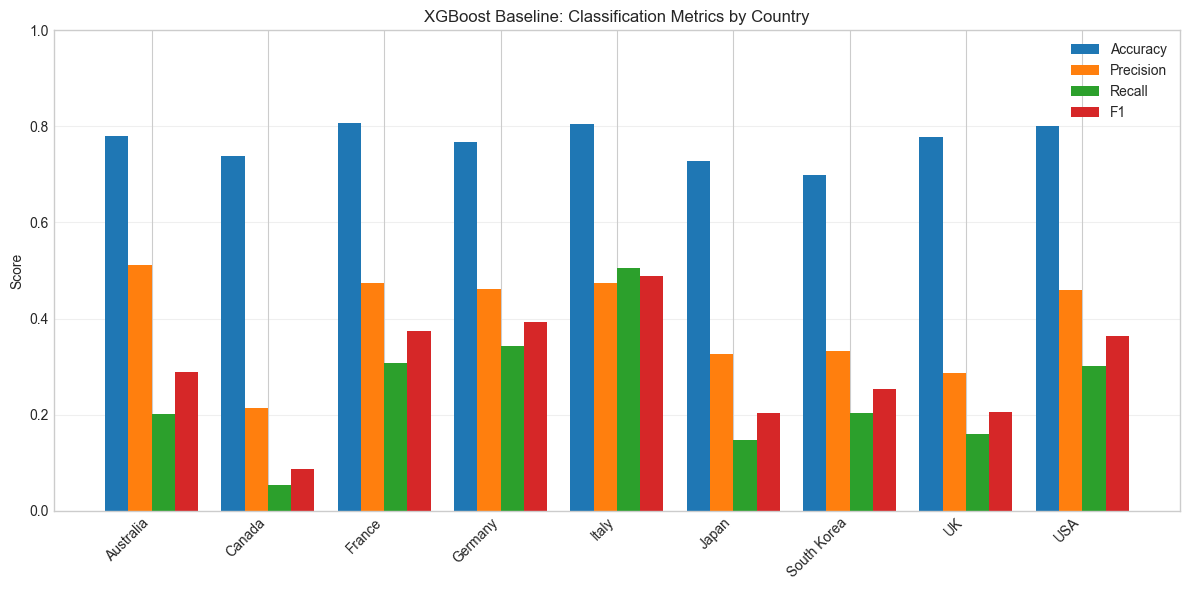

In [25]:
# Per-country classification metrics across all CV folds
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Re-run CV, collecting predictions with country labels
all_preds = []

tscv = TimeSeriesSplit(n_splits=5)
for fold, (train_idx, test_idx) in enumerate(tscv.split(X_clean)):
    X_train, X_test = X_clean.iloc[train_idx], X_clean.iloc[test_idx]
    y_train, y_test = y_clean.iloc[train_idx], y_clean.iloc[test_idx]
    countries_test = df_flat_clean.iloc[test_idx]['country'].values

    model_clean.fit(X_train, y_train)
    y_pred = model_clean.predict(X_test)
    y_proba = model_clean.predict_proba(X_test)[:, 1]

    fold_df = pd.DataFrame({
        'country': countries_test,
        'y_true': y_test.values,
        'y_pred': y_pred,
        'y_proba': y_proba,
        'fold': fold + 1
    })
    all_preds.append(fold_df)

pred_df = pd.concat(all_preds, ignore_index=True)

# Compute per-country metrics
country_metrics = []
for country in sorted(pred_df['country'].unique()):
    mask = pred_df['country'] == country
    yt = pred_df.loc[mask, 'y_true']
    yp = pred_df.loc[mask, 'y_pred']
    yprob = pred_df.loc[mask, 'y_proba']

    metrics = {
        'Country': country,
        'Accuracy': accuracy_score(yt, yp),
        'Precision': precision_score(yt, yp, zero_division=0),
        'Recall': recall_score(yt, yp, zero_division=0),
        'F1': f1_score(yt, yp, zero_division=0),
        'ROC-AUC': roc_auc_score(yt, yprob) if yt.nunique() > 1 else np.nan,
        'Support (pos)': int(yt.sum()),
        'Total': len(yt)
    }
    country_metrics.append(metrics)

metrics_df = pd.DataFrame(country_metrics).set_index('Country')

print("Classification Metrics by Country (aggregated across all CV folds)")
print("=" * 90)
print(metrics_df.to_string(float_format='{:.3f}'.format))

# Overall metrics for comparison
print(f"\nOverall:  Accuracy={accuracy_score(pred_df['y_true'], pred_df['y_pred']):.3f}  "
      f"Precision={precision_score(pred_df['y_true'], pred_df['y_pred'], zero_division=0):.3f}  "
      f"Recall={recall_score(pred_df['y_true'], pred_df['y_pred'], zero_division=0):.3f}  "
      f"F1={f1_score(pred_df['y_true'], pred_df['y_pred'], zero_division=0):.3f}  "
      f"ROC-AUC={roc_auc_score(pred_df['y_true'], pred_df['y_proba']):.3f}")

# Grouped bar chart
fig, ax = plt.subplots(figsize=(12, 6))
plot_metrics = ['Accuracy', 'Precision', 'Recall', 'F1']
x = np.arange(len(metrics_df))
width = 0.2

for i, metric in enumerate(plot_metrics):
    ax.bar(x + i * width, metrics_df[metric], width, label=metric)

ax.set_xticks(x + width * 1.5)
ax.set_xticklabels(metrics_df.index, rotation=45, ha='right')
ax.set_ylabel('Score')
ax.set_title('XGBoost Baseline: Classification Metrics by Country')
ax.set_ylim(0, 1)
ax.legend()
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

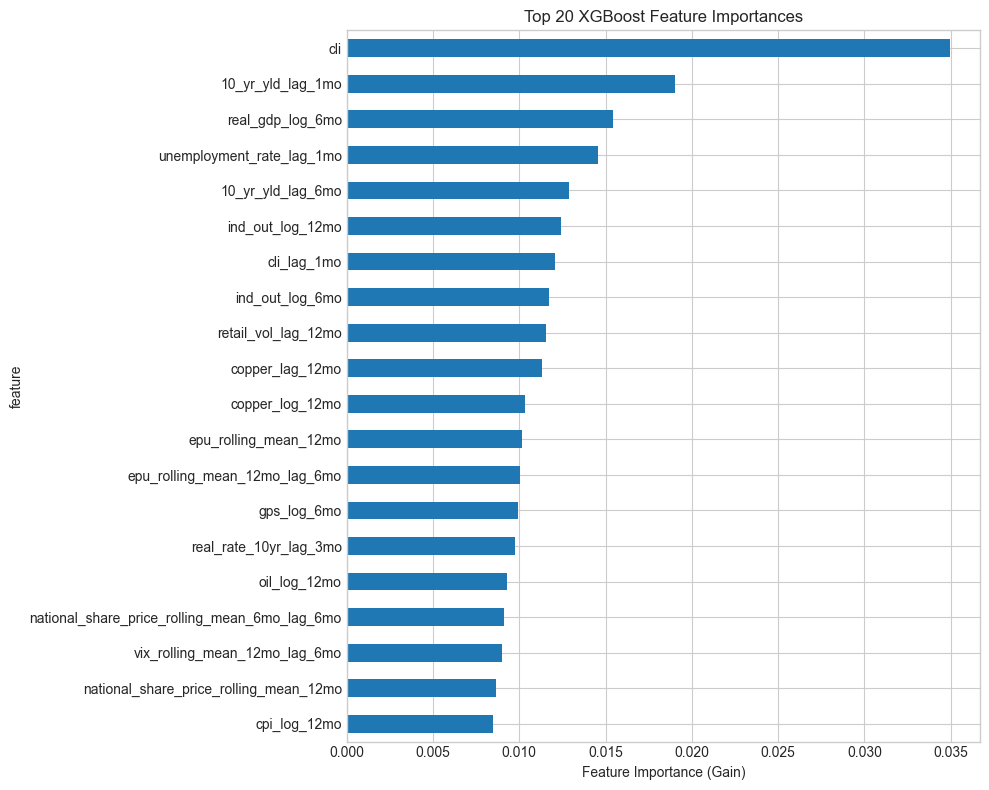


Top 10 most important features:
                  feature  importance
                      cli    0.034952
        10_yr_yld_lag_1mo    0.019053
         real_gdp_log_6mo    0.015462
unemployment_rate_lag_1mo    0.014559
        10_yr_yld_lag_6mo    0.012876
         ind_out_log_12mo    0.012427
              cli_lag_1mo    0.012045
          ind_out_log_6mo    0.011711
      retail_vol_lag_12mo    0.011548
          copper_lag_12mo    0.011316


In [27]:
# Feature importance from the last fold model
importances = pd.DataFrame({
    'feature': feature_cols,
    'importance': model_clean.feature_importances_
}).sort_values('importance', ascending=False)

# Plot top 20 features
fig, ax = plt.subplots(figsize=(10, 8))
top_n = 20
importances.head(top_n).plot(
    kind='barh', 
    x='feature', 
    y='importance', 
    ax=ax, 
    legend=False
)
ax.set_xlabel('Feature Importance (Gain)')
ax.set_title(f'Top {top_n} XGBoost Feature Importances')
ax.invert_yaxis()
plt.tight_layout()
plt.show()

print(f"\nTop 10 most important features:")
print(importances.head(10).to_string(index=False))

#### XGBoost Baseline Summary

**Model Configuration:**
- XGBoost classifier with default hyperparameters (100 trees, max_depth=6, lr=0.1)
- `scale_pos_weight` to handle class imbalance
- Time-series cross-validation with 5 expanding window folds

**Key Observations:**
- XGBoost handles missing values natively - no imputation needed
- Time-based CV prevents look-ahead bias (critical for forecasting tasks)
- PR-AUC is more informative than ROC-AUC for imbalanced classes

**Next Steps for Improvement:**
1. Hyperparameter tuning (max_depth, learning_rate, n_estimators)
2. Feature selection based on importance scores
3. Try alternative thresholds based on precision-recall trade-offs
4. Compare with other models (Logistic Regression, Random Forest, LightGBM)